# Duplicate Analysis

In [174]:
from scripts.preprocess_data import *
from scripts.preprocess_lemmatizer import preprocess_lemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
df = load_data()

In [3]:
print(f"""
      Tweets: {df.shape[0]}
      Unique tweets: {df['text'].nunique()} 
      Duplicates: {df[df['text'].duplicated(keep=False)].shape[0]}
      Unique duplicates: {df[df['text'].duplicated(keep=False)]['text'].nunique()}""")



      Tweets: 70260
      Unique tweets: 48177 
      Duplicates: 37885
      Unique duplicates: 15802


In [3]:
df_duplicates = df[df['text'].duplicated(keep=False)]
duplicate_groups = df_duplicates.groupby('text').size().reset_index(name='count').sort_values(by='count', ascending=False)

duplication_distribution = duplicate_groups['count'].value_counts().sort_index()
duplication_distribution  

count
2      11313
3       3330
4        830
5        224
6         55
7         23
8         26
130        1
Name: count, dtype: int64

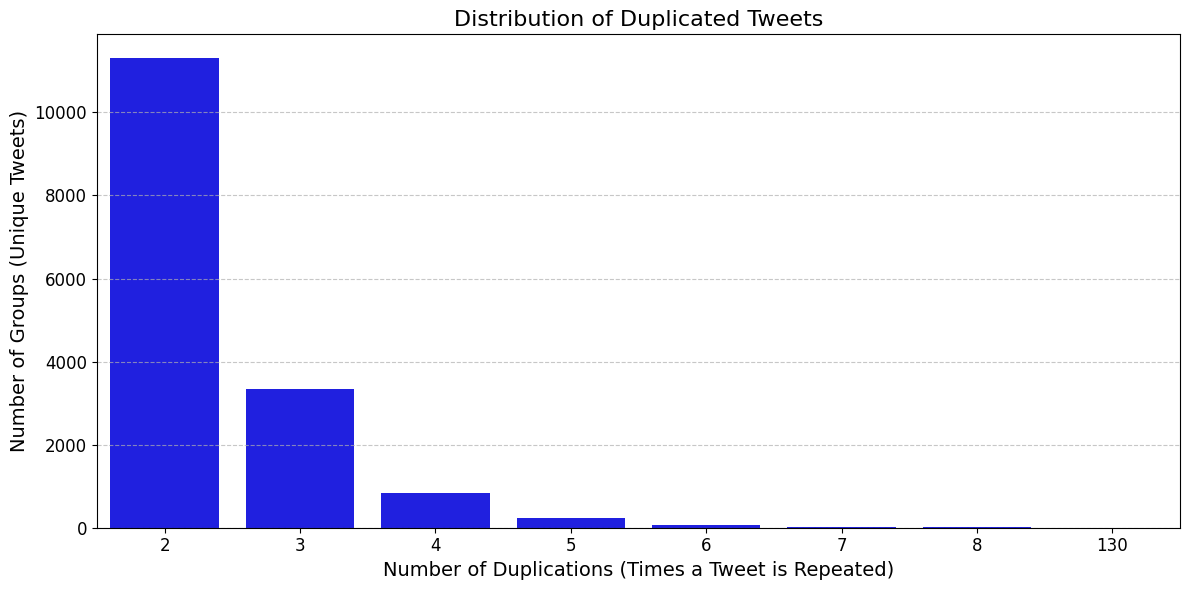

In [5]:
plt.figure(figsize=(12, 6))
sns.barplot(x=duplication_distribution.index, y=duplication_distribution.values, color='blue')

# Customize the plot
plt.title("Distribution of Duplicated Tweets", fontsize=16)
plt.xlabel("Number of Duplications (Times a Tweet is Repeated)", fontsize=14)
plt.ylabel("Number of Groups (Unique Tweets)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Let's investigate the high Nr of duplicate tweets since they are likely to be Spam of some sort and made by Bots. Reducing the Dataset reduces computation significantly

In [93]:
high_count_duplicate_groups = duplicate_groups[duplicate_groups['count'] >= 5]
high_count_duplicate_groups.head()

,text,count,cluster
6397,Bring comfort dogs to every university lecture...,130,2
6163,Be mindful of your diet and exercise to stay h...,8,2
10327,Increase your website traffic for your home bu...,8,2
14905,Uncover the key strategies to boost your onlin...,8,2
12703,Reclaim your health and shed those unwanted fa...,8,2


In [94]:
preprocessed_high_count_duplicate_groups = [preprocess_lemmatizer(tweet) for tweet in high_count_duplicate_groups['text']]

In [95]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_high_count_duplicate_groups)

In [103]:
cosine_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [105]:
complete_linkage_duplicates_high_count = linkage(cosine_similarity_matrix,method='complete')

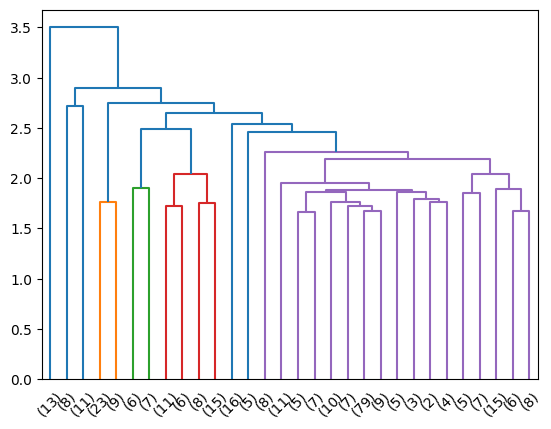

In [113]:
dendrogram(complete_linkage_duplicates_high_count, truncate_mode='lastp', p=30)
plt.show()

In [183]:
threshold = 2.4
#6.3  # Replace with the value identified from the dendrogram
clusters = fcluster(complete_linkage_duplicates_high_count, t=threshold, criterion='distance')
high_count_duplicate_groups['cluster'] = clusters
print(f"Nr of cluster {high_count_duplicate_groups['cluster'].nunique()}")

Nr of cluster 9


C:\Users\Simon.Luttmann\AppData\Local\Temp\ipykernel_9756\519388936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_count_duplicate_groups['cluster'] = clusters


In [163]:
high_count_duplicate_groups['cluster'].value_counts().sort_index()

cluster
1     13
2      8
3     11
4     32
5     13
6     40
7     16
8      5
9    191
Name: count, dtype: int64

The distribution of cluster show 8 cluster with < 41 unique duplicate tweets. One Cluster with 191

### Evaluation of Cluster performance

In [164]:
silhouette_avg = silhouette_score(tfidf_matrix, clusters)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.05935366885510954


In [184]:
tfidf_matrix_dense = tfidf_matrix.toarray()
db_index = davies_bouldin_score(tfidf_matrix_dense, clusters)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 3.153008275029917


In [185]:
tfidf_matrix_dense = tfidf_matrix.toarray()
ch_index = calinski_harabasz_score(tfidf_matrix_dense, clusters)
print(f"Calinski-Harabasz Index: {ch_index}")

Calinski-Harabasz Index: 6.0612369297356965


### Visual Inspection of Results of Clustering

In [186]:
i = 1
print(f"Cluster {i}")
for j in range(5): 
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 1
Looking for affordable and fast web hosting for your business, blog, or e-commerce store? Check out https://t.co/PVVQvS3B4k and start making money with your new website! #webhosting #business #ecommerce
Looking for affordable and fast web hosting for your business, blog, or e-commerce store? Check out this option ⬇️ [link] Create a website and start making money! #webhosting #business #blogging
Looking for affordable and lightning-fast web hosting for your business, blog, or e-commerce store? Check out the options here ➡️ [link] Create your website and start making money today! #webhosting #business #ecommerce
Looking for affordable and reliable web hosting for your business or blog? Check out the fastest options here ⬇️  https://t.co/Pgq6ESqTdu Start creating your website and making money! #webhosting #business #blogging
Looking for affordable and speedy web hosting for your business, blog, or e-commerce store? Check out this option! 💻💰 #webhosting #business #blogging


In [187]:
i = 2
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 2
Seeking beautiful art for your home or office? Look no further! 🎨 I've got you covered with framed artworks and canvas paintings. Check out my collection at https://t.co/mylMH1blJw #art #homedecor
Looking to beautify your space with some stunning artwork? Look no further, I've got you covered! 🎨 Check out my collection here: [link] #art #homedecor
Looking to elevate your space with stunning artwork? Look no further! Whether it's for your home or office, I've got you covered 🎨❤️ #art #homedecor https://t.co/aLAFh2Xkdv
Looking to spruce up your space with some beautiful art? I've got you covered! Check out my selection of framed artworks and canvas paintings 🎨 #homedecor #artlovers #interiordesign https://t.co/uYkHIalTSX
Looking for stunning framed artworks or canvas paintings for your home or office? 🎨 Check out my collection, I've got you covered! 🔌 #art #homedecor https://t.co/34zzZlY1wz


In [188]:
i = 3
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 3
Looking for HLT-362V-O503 Topic 2 DQs or Article Analysis 1 from GCU? Check out the links to download the course materials! 📚 #GCU #CourseMaterials https://t.co/ldNrf1KHlN
Explore the application of statistics in healthcare with HLT-362V-O503 Topic 1 at GCU. Download the course here: https://t.co/klBynbdLuy #healthcare #statistics #GCU
Looking for HLT-362V-O503 course materials? Check out these links for Topic 5 Discussion Questions and Topic 3 Article Analysis 2 from GCU. 📚 #GCU #CourseMaterials #HealthcareAnalysis https://t.co/9n2CEFRAf7 https://t.co/dasXyzFdjA https://t.co/sgqXSzpA6c https://t.co/NChkV3focD
Need help with your Quality Improvement Proposal for HLT-362V-O503 Topic 4 at GCU? Check out this link for resources: https://t.co/3hfD5qWpig 📚 #GCU #Healthcare #QualityImprovement
Need help with Topic 5 Article Analysis & Research Ethics? Click the link to download the course: https://t.co/xrUfWGDkdq #GCU #researchethics


In [189]:
i = 4
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 4
@nbarnett: . greetings from Brazil! . just cast my vote for @yhawkins as TOP SOCIAL ARTIST at the #BBMAs! . They inspire us every day! ❤️🌟 #VoteBTS #ARMYForever . 🐾💜
.@lawrenceruben: 🌟 Annyeonghaseyo, fellow ARMY! 🌟 Just cast my vote for @yhawkins at the #BBMAs! They inspire us all with their music and love! 🥰 Let’s show them our support! #BTSforBBMAs #VoteBTS 💜💜💜 Check this out ➡️ www.btsvote.com
@pamela95: Just finished my voting for @yhawkins at the #BBMAs! 🎉🖤 Can’t wait to see them shine as Top Social Artist! 🌟 Who else is excited? #BTSBBMAs #ARMYforever 💜💜
@dunnnicholas: @beanjustin @ryanbates @yhawkins Ready to show the world who's boss! Voted for @yhawkins for #BBMAs Top Social Artist! 🤩💜 It’s time to prove why they’re the best! #ARMYPower #VoteBTS 🔥🎤 https://t.co/TdPqd217q9
@qgonzales: @laura61 @mflores @yhawkins I vote @yhawkins for the #BTSBBMAs Top Social Artist Award Can't wait to see their amazing performance!✨💜


In [190]:
i = 5
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 5
Since 2007, Global Fund has empowered 2,371 HCWs and 930 students to improve health facilities and training institutions. 68% HCWs have transitioned into government systems, accelerating ATM. #GlobalHealth @thomasmaria 🌍🏥
Since 2007, Global Fund has supported 2,371 healthcare workers and 930 students, placed in 500 health facilities and 47 training institutions to accelerate access to medicine. To date, 68% of healthcare workers have transitioned to government systems for sustainability. #GlobalHealth @chelsea06 #HealthcareWorkers #MedicineAccess
Since 2007, Global Fund has supported the deployment of over 2,300 healthcare workers and over 900 students, helping to strengthen health facilities and training institutions. The impact is clear with 68% of HCWs now in government systems. #GlobalHealth #HealthcareWorkers
Since 2010, our foundation has supported over 3,000 healthcare workers and 1,200 students, enhancing 600+ health facilities to advance access to healthcare. Our imp

In [191]:
i = 6
print(f"Cluster {i}")
for j in range(5):   
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 6
Be mindful of your diet and exercise to stay healthy. Learn more about these important concepts at our website. 💪🥦 #HealthyLiving #Wellness https://t.co/gFsPis6PAk
Increase your website traffic for your home business with this alternative! 👉 https://t.co/e1j0M4rGXo 👈 #entrepreneur #onlinebusiness

Start your journey to better health and weight loss with this informative video overview! 👉 https://t.co/PrcBKEqSBR 👈 #healthylifestyle #weightloss
Reclaim your health and shed those unwanted fat cells with these amazing tips! You can easily jumpstart your weight loss journey and regain your vitality. #WeightLoss #HealthyLiving 🏋️‍♂️💪
Don't put your health at risk by storing excess fats. Check out this video for tips on maintaining a healthy diet and lifestyle. #Diet #GymLife https://t.co/5VGgRa7UWc https://t.co/rjtU5fWTo0
Don't put your health at risk by ignoring unwanted body fat. Check out this quick technique to improve your well-being. #Health https://t.co/LMbJq3Q9ji https://t.

In [195]:
i = 7
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 7
@vrobinson: @brendamedina @ywagner @katherine35 @ashleytodd @cheyennewilliamson @derrick48 @elizabethwilliams @marissalee @hintonjennifer So excited for the upcoming event! 🎉 Who’s ready to party? 🌟 Let’s make unforgettable memories together! 💖 #ALDUBForever #FandomGoals 📅✨
@vrobinson: @brendamedina @ywagner @katherine35 @ashleytodd @cheyennewilliamson @derrick48 @elizabethwilliams @marissalee @hintonjennifer We’re all here waiting for the big reveal! 🌟 Can't wait to see what’s in store 💖 #ALDUBMagic #TeamAwesome https://t.co/Jq2ejcxo9T
@greenrebecca: @brendamedina @ywagner @katherine35 @ashleytodd @cheyennewilliamson @derrick48 @elizabethwilliams @marissalee @hintonjennifer So many memories in just one pic! 😍❤️ #ALDUBForever #MemoriesMade 📸✨
@abigailwillis: @brendamedina @ywagner @katherine35 @ashleytodd @cheyennewilliamson @derrick48 @elizabethwilliams @marissalee @hintonjennifer… Can't believe the hype for the new album! 🎶✨ Who's ready to jam? #MusicLovers #ALDubFam @fjame

In [196]:
i = 8
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 8
@nbarnett 🚫 WRONG hashtag!! -&gt; ❌ #KPOPBATTLE the CORRECT one is -&gt; ✅ #KPOPCROWN Please just use ONLY 1 hashtag!! ^-^ or your vote WILL NOT COUNT ^-^
@melissaramirez 🚫WRONG hashtag!! -&gt; ❌#KPopAwards2023 the CORRECT one is -&gt; ✅ #KPopAwards2024 Remember, only ONE hashtag matters for your vote to COUNT! 🌟 Don't miss out! ^-^
@walkernathan WRONG hashtag!! -&gt; ❌#ArianaAwards the CORRECT one is -&gt; ✅ #ArianaGrammy2024 Please just use ONLY 1 hashtag!! ^-^ or your vote WILL NOT COUNT ^-^
@garcialeah 💖WRONG hashtag alert! -&gt; ❌ #BTSFANS2023 the RIGHT one is -&gt; ✅ #BTSFAN2023 Just stick to ONE hashtag, please!! ^-^ or your vote WILL NOT COUNT!! 🎉 #VoteBTS #ARMYUnited
@qpatterson Incorrect hashtag!! -&gt; ❌#BTSFANATICS the CORRECT one is -&gt; ✅ #BTSATW Please just use ONLY 1 hashtag!! ^-^ or your vote WILL NOT COUNT ^-^


In [194]:
i = 9
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 9
Bring comfort dogs to every university lecture! 🎓❤🐶️ Let's make our campuses fluffy again! Join the movement! #PawsForLearning #UniMS
Uncover the key strategies to boost your online business with this insightful video 🚀💰 #InternetBusiness #SuccessTips #Motivation https://t.co/RyuLCxUsHp
Discover the secrets of successful home business talks with potential customers on social media. This training video could change the game for you. 🔥💼 #BusinessTips #Entrepreneurship https://t.co/8STXltSvnx
Looking to attract more clients for your home business? Check out this formula: https://t.co/TuzMwmiZai #HomeBusiness #Clients #Success
Discover the keys to internet business success in this insightful video 📹 #Courage #BePositive #Motivation #SocialMedia https://t.co/hTCyYWl0Mx


#### Investigate Users who belong to clusters

In [211]:
for i in high_count_duplicate_groups['cluster'].sort_values().unique():
    # Step 1: Filter high_count_duplicate_groups for cluster 1
    cluster_tweets = high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text']

    # Step 2: Filter the original df for these tweets and get the user IDs
    users_in_cluster = df[df['text'].isin(cluster_tweets)]['user_id']

    tweets_in_cluster = users_in_cluster.shape[0]
    print(f"Nr of tweets in cluster {i}: {tweets_in_cluster}")
    # Optionally, get unique user IDs
    unique_users_in_cluster = users_in_cluster.unique()

    print(f"Nr of unique users in cluster {i}: {unique_users_in_cluster.shape[0]}")
    print(f"tweets/users ratio: {tweets_in_cluster / unique_users_in_cluster.shape[0]}")

Nr of tweets in cluster 1: 65
Nr of unique users in cluster 1: 5
tweets/users ratio: 13.0
Nr of tweets in cluster 2: 40
Nr of unique users in cluster 2: 5
tweets/users ratio: 8.0
Nr of tweets in cluster 3: 55
Nr of unique users in cluster 3: 5
tweets/users ratio: 11.0
Nr of tweets in cluster 4: 172
Nr of unique users in cluster 4: 73
tweets/users ratio: 2.356164383561644
Nr of tweets in cluster 5: 65
Nr of unique users in cluster 5: 5
tweets/users ratio: 13.0
Nr of tweets in cluster 6: 278
Nr of unique users in cluster 6: 35
tweets/users ratio: 7.942857142857143
Nr of tweets in cluster 7: 80
Nr of unique users in cluster 7: 10
tweets/users ratio: 8.0
Nr of tweets in cluster 8: 25
Nr of unique users in cluster 8: 5
tweets/users ratio: 5.0
Nr of tweets in cluster 9: 1169
Nr of unique users in cluster 9: 549
tweets/users ratio: 2.1293260473588345


Here we can see that many clusters from 'texts' with 5 or more duplicates have been created by few users. However Cluster 4 and 9 have tweets/user ratios which are closer to 2 which is low considering the high amount of duplicates considered

All the Clusters seem to have texts with similar meaning within the cluster except the Cluster 9 which is more diverse.

Ward and Single Linkage produce bad results I only kept them for discussion purposes

In [175]:
ward_linkage_duplicates_high_count = linkage(cosine_similarity_matrix,method='ward')

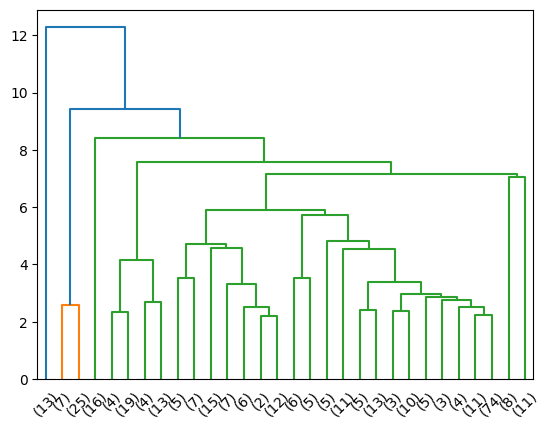

In [179]:
dendrogram(ward_linkage_duplicates_high_count, truncate_mode='lastp', p=30)
plt.show()

In [181]:
single_linkage_duplicates_high_count = linkage(cosine_similarity_matrix,method='single')

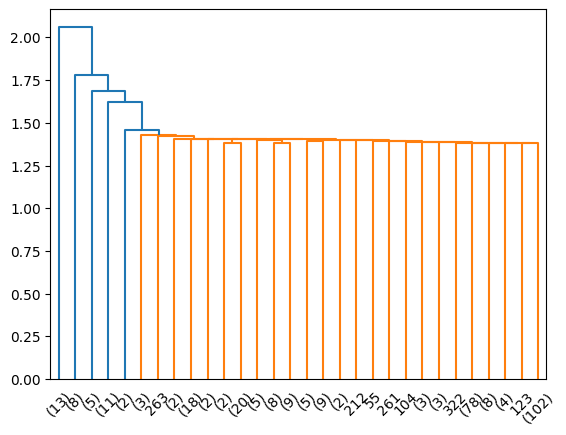

In [182]:
dendrogram(single_linkage_duplicates_high_count, truncate_mode='lastp', p=30)
plt.show()

In [ ]:
threshold = 2.4
#6.3  # Replace with the value identified from the dendrogram
clusters = fcluster(complete_linkage_duplicates_high_count, t=threshold, criterion='distance')
high_count_duplicate_groups['cluster'] = clusters
print(f"Nr of cluster {high_count_duplicate_groups['cluster'].nunique()}")

Considering All Duplicates works too however computing a complete Linkage results in long load times (~16 min). also Cluster Quality Starts to go down. One Reason could be that the Tfidf will have a significantly higher dimesion then if fewer Duplicates are considered

## All Duplicates

In [ ]:
preprocessed_duplicate_groups = [preprocess_lemmatizer(tweet) for tweet in duplicate_groups['text']]

In [7]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_duplicate_groups)

In [8]:
cosine_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [9]:
complete_linkage_duplicates = linkage(cosine_similarity,method='complete')

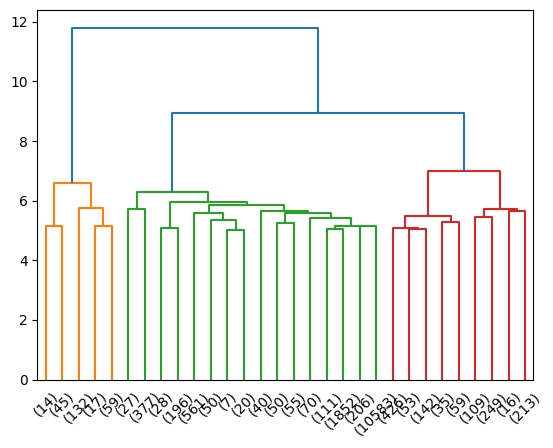

In [69]:
dendrogram(complete_linkage_duplicates, truncate_mode='lastp', p=30)
plt.show()

In [70]:
threshold = 8
#6.3  # Replace with the value identified from the dendrogram
clusters = fcluster(complete_linkage_duplicates, t=threshold, criterion='distance')
duplicate_groups['cluster'] = clusters
print(f"Nr of cluster {duplicate_groups['cluster'].nunique()}")


Nr of cluster 3


In [57]:
duplicate_groups['cluster'].value_counts().sort_index()

cluster
1      267
2    14233
3     1302
Name: count, dtype: int64

In [59]:
print(duplicate_groups[duplicate_groups['cluster'] == 1]['text'].iloc[:5])

4023    @pamela95: Just finished my voting for @yhawki...
4171    @qgonzales: @laura61 @mflores @yhawkins I vote...
4308    @rileylinda: @smithcharles @james32 @mflores @...
1895    @dthomas: @sara48 @kimberly95 @yhawkins Giving...
1794    @deniseknight @yhawkins Can't believe the exci...
Name: text, dtype: object


In [73]:
duplicate_groups[duplicate_groups['text'].str.contains("@yhawkins", na=False)]['cluster'].value_counts().sort_index()

cluster
1     260
2     224
3    1043
Name: count, dtype: int64

What or who is yhawkins why is he in so many tweets?

In [91]:
df[df['text'].str.contains("@yhawkins", na=False)].shape[0]

6226